# 1. Model
## Data Preprocessing & EDA
Data contains 41188 observations and 21 features. Response y refers to whether or not the client subscribe the term deposite.

In [ ]:
import pandas as pd

import numpy as npn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.utils import resample

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score,roc_curve


In [ ]:
def conversion_rate_by_cat(varname):
  '''
  varname(str): variable name such as 'job', 'education', etc.'''
  job_y=pd.concat([df[varname],df['y']],axis=1)
  counts_by_job=job_y.groupby([varname,'y']).size().unstack()
  conversion_rate_by_job=counts_by_job['yes']/(counts_by_job['yes']+counts_by_job['no'])

  conversion_rate_by_job=conversion_rate_by_job.reset_index()
  conversion_rate_by_job.columns=[varname,'proportion']

  plt.xticks(rotation=45)
  plt.bar(conversion_rate_by_job[varname],conversion_rate_by_job['proportion'],color='salmon',alpha=0.6)
  plt.axhline(y=base_conversion_rate, color='blue', linestyle='--')
  plt.title(f'Subscription proportion by {varname}')

  return conversion_rate_by_job


def find_correlated_variable(df_num,threshold):
  '''
  df_num: numerical dataframe
  find highly correlated NUMERICAL variables with correlation>threshold'''
  cor=df_num.corr()
  high_cor_var=[]
  threshold=0.8
  for i in range(len(cor.columns)):
    for j in range(len(cor.columns)):
       if i>j and abs(cor.iloc[i,j])>threshold:
           high_cor_var.append((cor.columns[i],cor.columns[j],cor.iloc[i, j]))
  return high_cor_var


def undersampling(df):
  no=df[df['y']==0]
  yes=df[df['y']==1]

  no_undersampled=resample(no,replace=False,n_samples=len(yes),random_state=123)

  df= pd.concat([no_undersampled,yes])
  return df

In [ ]:
df=pd.read_csv('./term deposit data.csv',delimiter=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


,education,proportion
0,basic.4y,0.102490
1,basic.6y,0.082024
2,basic.9y,0.078246
3,high.school,0.108355
4,illiterate,0.222222
5,professional.course,0.113485
6,university.degree,0.137245
7,unknown,0.145003


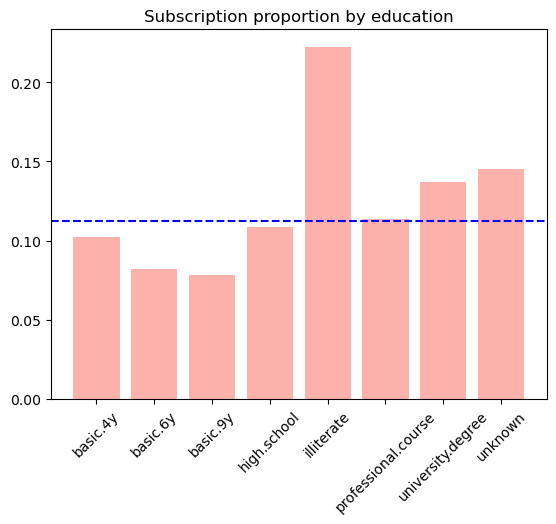

In [ ]:
base_conversion_rate=(df['y']=='yes').sum()/df.shape[0]
conversion_rate_by_cat('education')

,job,proportion
0,admin.,0.129726
1,blue-collar,0.068943
2,entrepreneur,0.085165
3,housemaid,0.100000
4,management,0.112175
5,retired,0.252326
6,self-employed,0.104856
7,services,0.081381
8,student,0.314286
9,technician,0.108260


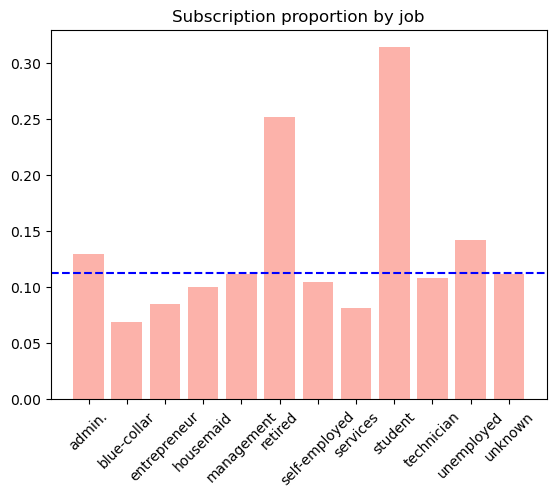

In [ ]:
conversion_rate_by_cat('job')

,month,proportion
0,apr,0.204787
1,aug,0.106021
2,dec,0.489011
3,jul,0.090466
4,jun,0.105115
5,mar,0.505495
6,may,0.064347
7,nov,0.101439
8,oct,0.438719
9,sep,0.449123


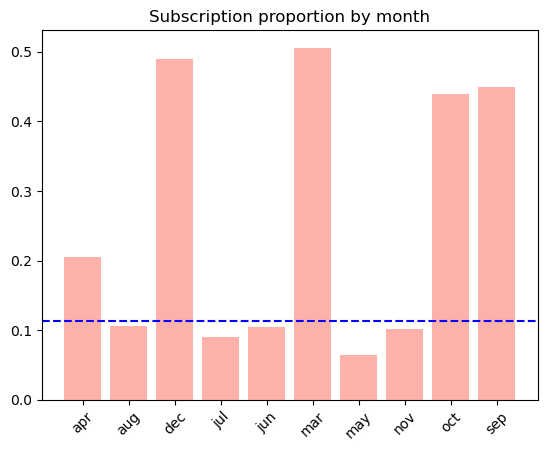

In [ ]:
conversion_rate_by_cat('month')

,housing,proportion
0,no,0.108796
1,unknown,0.108081
2,yes,0.116194


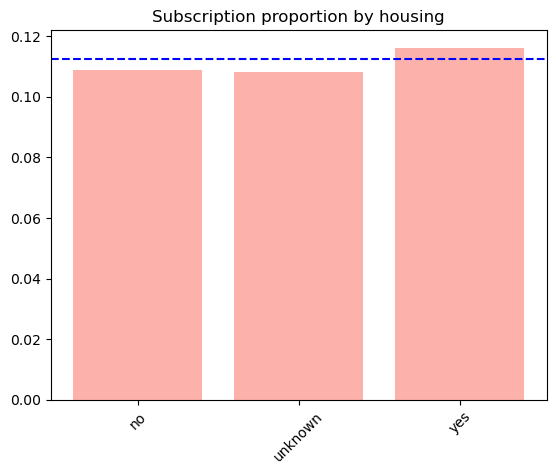

In [ ]:
conversion_rate_by_cat('housing')

In [ ]:
df['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], dtype=object)

y         no  yes
month            
mar      270  276
apr     2093  539
may    12883  886
jun     4759  559
jul     6525  649
aug     5523  655
sep      314  256
oct      403  315
nov     3685  416
dec       93   89


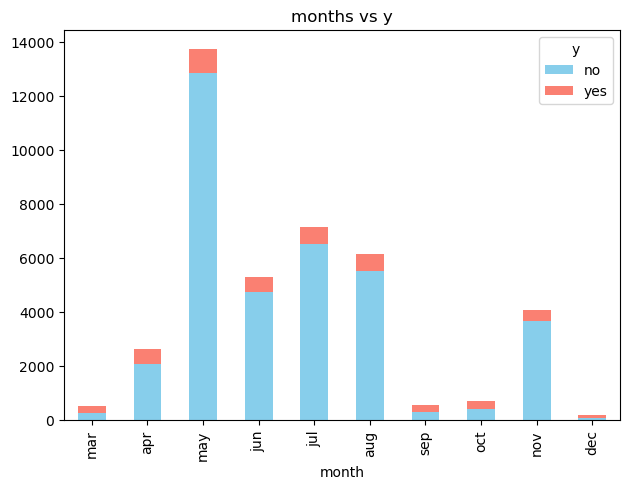

In [ ]:
month=df.groupby(['month','y']).size().unstack()
month_order = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
month_oredered = month.reindex(month_order)
print(month_oredered)
month_oredered.plot(kind='bar',stacked=True,color=['skyblue','salmon'])
plt.tight_layout()
plt.title('months vs y')
plt.show()

In [ ]:
#substitute missing values by mode

##job and education
for i in ['job','education','marital']:
    df[i].value_counts()
    mode=df[df[i]!='unkown'][i].mode()
    df[i] = df[i].replace('unknown', mode[0])



In [ ]:
y=df.pop("y")
mapping={'yes':1,'no':0}
y=y.map(mapping)
#numerical vars: remove correlated var
df_num=df.select_dtypes(include=['number'])

find_correlated_variable(df_num,0.8)
df_uncor=df_num.drop(columns=["emp.var.rate","nr.employed"])

In [ ]:
#categorical vars: one hot encoding
#transform education
df_cat=df.select_dtypes(include='object')

def map_edu(edu):
  if 'basic' in edu:
    return 'basic'
  elif 'professional' in edu or 'university.degree' in edu:
    return 'university'
  else:
    return edu
df_cat['education']=df_cat['education'].map(map_edu)

df_cat=pd.get_dummies(df_cat)
df2=pd.concat([df_uncor,df_cat],axis=1)

In [ ]:
#test train split - performs better only using df_num
X_train,X_test,y_train,y_test=train_test_split(df2,y,test_size=0.2,random_state=123)
Xy_train=pd.concat([X_train,y_train],axis=1)
undersampled_Xy_train = undersampling(Xy_train)
undersampled_y_train=undersampled_Xy_train.pop('y')
undersampled_X_train=undersampled_Xy_train

## Logistic Regression
1. undersampled logistic regression
2. original logistic regression

In [ ]:
logreg_under = LogisticRegression(random_state=123)
logreg_under.fit(undersampled_X_train, undersampled_y_train)
y_pred=logreg_under.predict(X_test)

cm_undersampled_logi=metrics.confusion_matrix(y_test,y_pred)
report_undersampled_logi=classification_report(y_test,y_pred)
print(cm_undersampled_logi)
print(report_undersampled_logi)

[[6153 1145]
 [ 120  820]]
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7298
           1       0.42      0.87      0.56       940

    accuracy                           0.85      8238
   macro avg       0.70      0.86      0.74      8238
weighted avg       0.92      0.85      0.87      8238



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)

cm_logi=metrics.confusion_matrix(y_test,y_pred)
report_logi=classification_report(y_test,y_pred)
print(cm_logi)
print(report_logi)

[[7144  154]
 [ 568  372]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7298
           1       0.71      0.40      0.51       940

    accuracy                           0.91      8238
   macro avg       0.82      0.69      0.73      8238
weighted avg       0.90      0.91      0.90      8238



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Random Forest
1. plain rf
2. rf via grid search

In [ ]:
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import GridSearchCV

In [ ]:
rf = RandomForestClassifier(random_state=123)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
#metrics
##cm
cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy = accuracy_score(y_test, y_pred)#not important
print(accuracy)

report = classification_report(y_test, y_pred)
print(report)

[[7058  240]
 [ 486  454]]
0.9118718135469774
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7298
           1       0.65      0.48      0.56       940

    accuracy                           0.91      8238
   macro avg       0.79      0.73      0.75      8238
weighted avg       0.90      0.91      0.91      8238



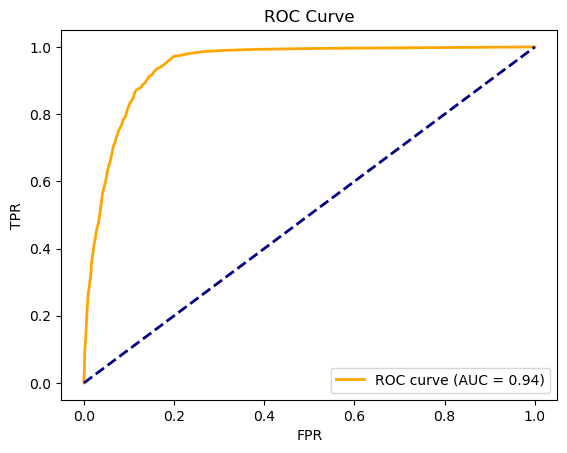

In [ ]:
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
'''
param_grid={
   'max_depth':list(range(10,101,20)),
   'max_features':[4,6,8],
   'min_samples_leaf':[3,4,5],
   'min_samples_split':[5,6,7],
   'n_estimators':[100,200]
}

grid_search_rf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,n_jobs=-1,scoring='f1')#default accuracy
grid_search_rf.fit(X_train,y_train)
grid_search_rf.best_params_
'''

"\nparam_grid={\n   'max_depth':list(range(10,101,20)),\n   'max_features':[4,6,8],\n   'min_samples_leaf':[3,4,5],\n   'min_samples_split':[5,6,7],\n   'n_estimators':[100,200]\n}\n\ngrid_search_rf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,n_jobs=-1,scoring='f1')#default accuracy\ngrid_search_rf.fit(X_train,y_train)\ngrid_search_rf.best_params_\n"

In [ ]:
best_rf_param={'max_depth':30,
 'max_features':10,
 'min_samples_leaf':3,
 'min_samples_split':7,
 'n_estimators':100}

best_rf=RandomForestClassifier(criterion='gini',max_depth=30,max_features=10,min_samples_leaf=3,min_samples_split=7,n_estimators=200)

In [ ]:
best_rf.fit(X_train,y_train)
best_rf_ypred=best_rf.predict(X_test)

In [ ]:
cm=confusion_matrix(y_test,best_rf_ypred)
print(cm)


report=classification_report(y_test,best_rf_ypred)
print(report)

[[7050  248]
 [ 457  483]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7298
           1       0.66      0.51      0.58       940

    accuracy                           0.91      8238
   macro avg       0.80      0.74      0.77      8238
weighted avg       0.91      0.91      0.91      8238



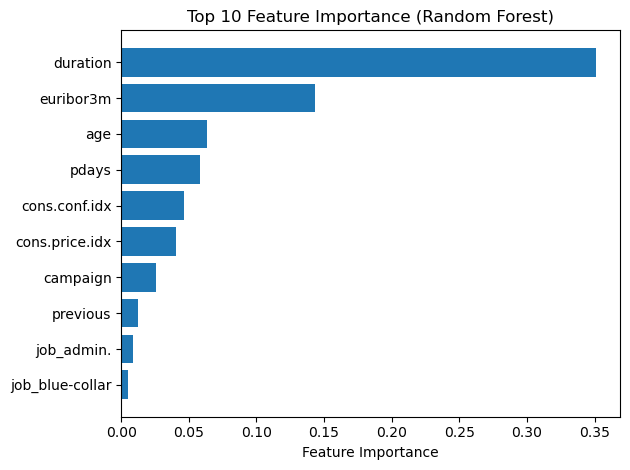

In [ ]:
feature_importance = best_rf.feature_importances_[0:10]

feature_names = X_train.columns
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure()
plt.barh(pos,feature_importance[sorted_idx], align='center')
plt.yticks(pos,feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()


## XGB

In [ ]:
from xgboost import XGBClassifier

xgb=XGBClassifier(random_state=123)
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)

cm=confusion_matrix(y_test,y_pred)
print(cm)

report = classification_report(y_test, y_pred)
print(report)

[[6970  328]
 [ 421  519]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7298
           1       0.61      0.55      0.58       940

    accuracy                           0.91      8238
   macro avg       0.78      0.75      0.76      8238
weighted avg       0.91      0.91      0.91      8238



In [ ]:
param_grid={'n_estimators':[100,200],
    'max_depth':[3,6,9],
    'learning_rate':[0.01,0.1, 0.2]}
 #   'subsample':[0.8,0.9,1.0],
 #   'colsample_bytree':[0.8,0.9,1.0]


xgb = XGBClassifier(eval_metric='mlogloss', random_state=123)
# Set up GridSearchCV
grid_search=GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',#####!!!
    cv=4,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train,y_train)

# Get the best parameters and best score
best_params=grid_search.best_params_
best_score=grid_search.best_score_

Fitting 4 folds for each of 18 candidates, totalling 72 fits


In [ ]:
#best parameters and cv score
best_params=grid_search.best_params_
best_score=grid_search.best_score_

best_xgb=grid_search.best_estimator_
y_pred=best_xgb.predict(X_test)
accuracy=accuracy_score(y_test, y_pred)

In [ ]:
#ensemble
from sklearn.ensemble import VotingClassifier

voting=VotingClassifier(estimators=[('rf',rf),('xgb',best_xgb),('log_reg', logreg)],voting='soft')

voting.fit(X_train,y_train)

y_pred = voting.predict(X_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
accuracy=accuracy_score(y_test, y_pred)
report=classification_report(y_test, y_pred)
cm=confusion_matrix(y_test,y_pred)
print(accuracy)
print(report)
print(cm)

0.9164845836368051
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7298
           1       0.70      0.48      0.57       940

    accuracy                           0.92      8238
   macro avg       0.82      0.72      0.76      8238
weighted avg       0.91      0.92      0.91      8238

[[7102  196]
 [ 492  448]]


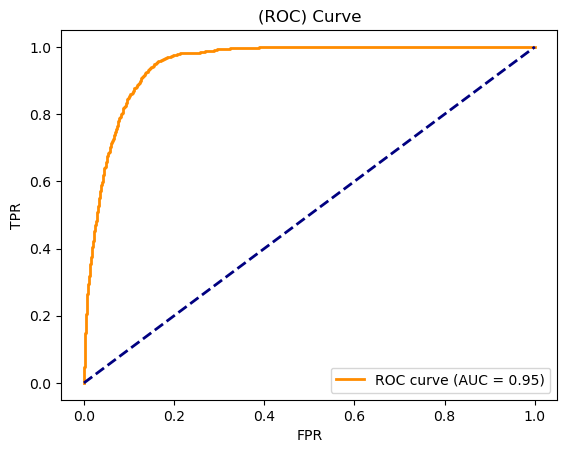

In [ ]:
y_prob = voting.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('(ROC) Curve')
plt.legend(loc="lower right")
plt.show()

For the deployment of the data, we consier wrap the model in a service and serive it through API using flasl or fastAPI. The marketing team can use API calls to use the model. This model provides in sights for client segementation and helps identifying marketing target.

Current data already includes the clients demogaphics, financial status, economic environments and phone contact details. Other data, such as geopspatial data, interest rates, customer surveys could also be helpful.

For contact duration for new clients, we consider impute it with a regression model first, then perform prediction.

**Key Summaries**
- Students, unemployed and retired people have high comversion rate
- Having housing loan or other loans did not affect conversion rate. However, we may dive a deeper look by further segmenting the clientns who have loans to see if there are patterns.
- We implemented several methods to perform the classification task, inclusing logistic regression, random forest and XGBoost. Since the dataset is unbalanced. We undersampled the data for logistic regression for a better results. For more robust methods such as random forest and XGBoost, we used unsampled training set.
- It is crutial to have a good balance between the precision and recall. However it depends on the actual business scenario to decide which metrics to ehphasize at.